In [1]:
import pandas as pd
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
transport = pd.read_csv('transport.csv')

In [15]:
transport_dates_corrected = []
for date in transport.Date.values:
    transport_dates_corrected.append(datetime.date(year=int(date[6:]), month=int(date[3:5]), day=int(date[:2])))

transport['Date_'] = transport_dates_corrected

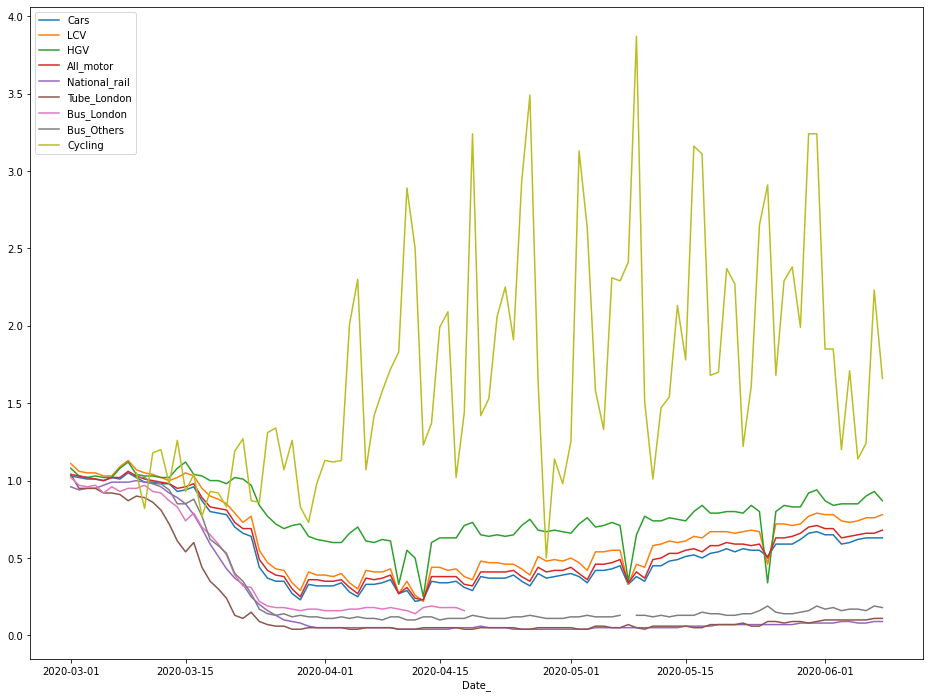

In [21]:
transport.plot('Date_', figsize=(16,12))
plt.show()

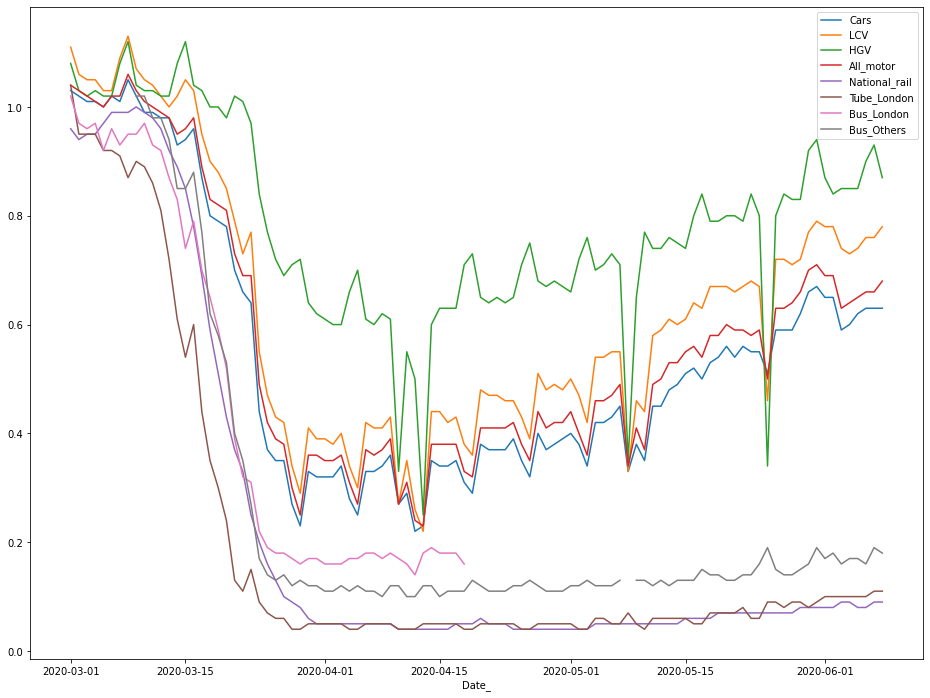

In [20]:
transport.drop('Cycling', axis=1).plot('Date_', figsize=(16,12))
plt.show()